# Import

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from datetime import datetime, timedelta, date
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn import preprocessing
import plotly.graph_objects as go
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() 

# pandas max row 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
#from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
#from keras.models import Sequential
#from keras.layers import Dense, LSTM
#from keras.preprocessing import sequence
#from keras.utils import np_utils
#from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.compat.v1.disable_v2_behavior() 

In [6]:
tf.__version__

'2.10.0'

In [1]:
import shap

# Data Load

In [7]:
df_train = pd.read_csv('../Data/train_time_data_pf.csv', encoding='cp949')

In [8]:
df_train['STD_DT'] = df_train['STD_DT'].apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d %H:%M:%S'))
df_train = df_train.set_index(['STD_DT'])

In [9]:
df_train.head(3)

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,Measurement_error,MW_Period_Second,TAG
STD_DT,,,,,,,,
2020-03-04 00:00:00,0,48.9,11.6,631.0,3.19,0,912,0
2020-03-04 00:00:06,1,43.3,7.8,609.0,3.19,0,912,0
2020-03-04 00:00:12,2,46.4,15.4,608.0,3.19,0,912,0


In [10]:
df_train.TAG = df_train.TAG.apply(lambda x :0 if x == 1 else 1)

In [11]:
df_train.head(3)

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,Measurement_error,MW_Period_Second,TAG
STD_DT,,,,,,,,
2020-03-04 00:00:00,0,48.9,11.6,631.0,3.19,0,912,1
2020-03-04 00:00:06,1,43.3,7.8,609.0,3.19,0,912,1
2020-03-04 00:00:12,2,46.4,15.4,608.0,3.19,0,912,1


In [12]:
df_train.TAG.value_counts()

1    350600
0    153400
Name: TAG, dtype: int64

In [13]:
df_test = pd.read_csv('../Data/validation_time_data_pf.csv', encoding='cp949')
df_test['STD_DT'] = df_test['STD_DT'].apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d %H:%M:%S'))
df_test = df_test.set_index(['STD_DT'])

In [14]:
df_test.head(3)

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,Measurement_error,MW_Period_Second,TAG
STD_DT,,,,,,,,
2020-04-08 00:00:00,504000,50.9,12.3,137.0,3.19,0,2832,0
2020-04-08 00:00:06,504001,43.5,7.6,136.0,3.19,0,2832,1
2020-04-08 00:00:12,504002,44.4,17.0,134.0,3.19,0,2832,1


In [15]:
df_test.TAG = df_test.TAG.apply(lambda x :0 if x == 1 else 1)

In [16]:
df_test.head(3)

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,Measurement_error,MW_Period_Second,TAG
STD_DT,,,,,,,,
2020-04-08 00:00:00,504000,50.9,12.3,137.0,3.19,0,2832,1
2020-04-08 00:00:06,504001,43.5,7.6,136.0,3.19,0,2832,0
2020-04-08 00:00:12,504002,44.4,17.0,134.0,3.19,0,2832,0


In [17]:
df_train = df_train.drop(columns = ['NUM'])
df_test = df_test.drop(columns = ['NUM'])

In [18]:
train = df_train.copy()
test = df_test.copy()

In [19]:
print(train.shape)
print(test.shape)

(504000, 7)
(331200, 7)


In [20]:
feature_cols = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'Measurement_error', 'MW_Period_Second']
label_cols = ['TAG']

In [21]:
feature_cols[:-1]

['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'Measurement_error']

In [22]:
scaler = preprocessing.MinMaxScaler()

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [23]:
X_train_values = train_sc[:,:-1]
y_train_values = train_sc[:,-1]

In [24]:
def make_dataset(data, label, window_size):
  feature_list = []
  label_list = []
  for i in range(len(data) - window_size):
    feature_list.append(np.array(data.iloc[i:i+window_size]))
    label_list.append(np.array(label.iloc[i+window_size]))
  return np.array(feature_list), np.array(label_list)

In [25]:
X_train = pd.DataFrame(X_train_values, columns=feature_cols)
y_train = pd.DataFrame(y_train_values, columns=label_cols)

In [26]:
train_feature, train_label = make_dataset(X_train, y_train, 20)

In [27]:
test_sc = pd.DataFrame(test_sc, columns=test.columns)

In [28]:
test_feature = test_sc[feature_cols]
test_label = test_sc[label_cols]

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((331180, 20, 6), (331180, 1))

In [29]:
test_sc.shape

(331200, 7)

In [30]:
test_feature.shape

(331180, 20, 6)

In [31]:
test_label.shape

(331180, 1)

In [32]:
# train, validation set 생성
X_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size = 0.3)
X_train.shape, x_valid.shape

((352786, 20, 6), (151194, 20, 6))

# CNN_LSTM

In [33]:
# LSTM 모델 구축
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(train_feature.shape[1], train_feature.shape[2])))
#model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))
#model.add(LSTM(units=25, return_sequences=True, activation='relu'))
#model.add(Dropout(0.2))
#model.add(LSTM(units=25, return_sequences=True, activation='relu'))
#model.add(Dropout(0.2))
#model.add(LSTM(units=25, return_sequences=True, activation='relu'))
model.add(LSTM(units=50, return_sequences=True, activation='relu'))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [38]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [34]:
model_path = '../Model'

In [35]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [36]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['acc',f1_m,precision_m, recall_m])
early_stop = EarlyStopping(monitor='val_loss', patience = 5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=0,
                             save_best_only=True, mode='auto')

In [37]:
tf.debugging.set_log_device_placement(True)

# 텐서를 CPU에 할당
with tf.device('/CPU:0'):
    history = model.fit(X_train, y_train,
                       epochs = 30,
                       batch_size = 50,
                       validation_data = (x_valid, y_valid)
                       , callbacks=[early_stop, checkpoint])

Train on 352786 samples, validate on 151194 samples
Epoch 1/30
352786/352786 [==============================] - ETA: 0s - loss: 48.6183 - acc: 0.6865 - f1_m: 0.7876 - precision_m: 0.7115 - recall_m: 0.9196

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


352786/352786 [==============================] - 583s 2ms/sample - loss: 48.6183 - acc: 0.6865 - f1_m: 0.7876 - precision_m: 0.7115 - recall_m: 0.9196 - val_loss: 0.6142 - val_acc: 0.6960 - val_f1_m: 0.8190 - val_precision_m: 0.6960 - val_recall_m: 1.0000
Epoch 2/30
352786/352786 [==============================] - 601s 2ms/sample - loss: 0.6147 - acc: 0.6955 - f1_m: 0.8186 - precision_m: 0.6955 - recall_m: 1.0000 - val_loss: 0.6142 - val_acc: 0.6960 - val_f1_m: 0.8191 - val_precision_m: 0.6960 - val_recall_m: 1.0000
Epoch 3/30
352786/352786 [==============================] - 603s 2ms/sample - loss: 0.6147 - acc: 0.6955 - f1_m: 0.8187 - precision_m: 0.6955 - recall_m: 1.0000 - val_loss: 0.6142 - val_acc: 0.6960 - val_f1_m: 0.8190 - val_precision_m: 0.6960 - val_recall_m: 1.0000
Epoch 4/30
352786/352786 [==============================] - 602s 2ms/sample - loss: 0.6147 - acc: 0.6955 - f1_m: 0.8187 - precision_m: 0.6955 - recall_m: 1.0000 - val_loss: 0.6142 - val_acc: 0.6960 - val_f1_m: 0.

In [93]:
model.load_weights('../Model/tmp_checkpoint_1.h5')

In [94]:
pred = model.predict(test_feature)

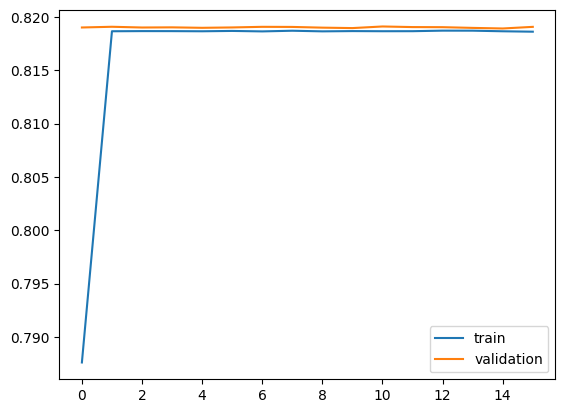

In [95]:
plt.plot(history.history['f1_m'], label='train')
plt.plot(history.history['val_f1_m'], label='validation')
plt.legend()
plt.show()

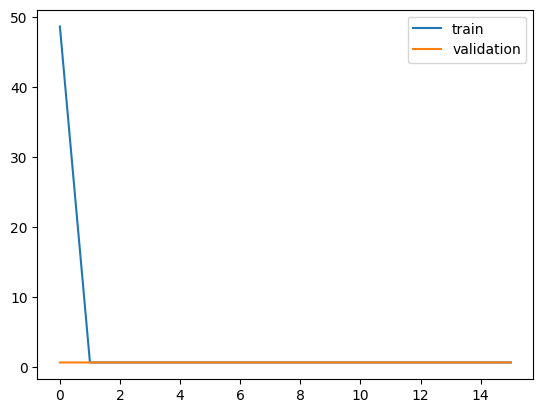

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [106]:
pred_df = pd.DataFrame(pred, columns= ['TAG'])

In [107]:
pred_df['TAG'] = pred_df['TAG'].apply(lambda x: 1 if x> 0.5 else 0)

In [108]:
pred_df['TAG'].value_counts()

1    289819
0     41361
Name: TAG, dtype: int64

In [109]:
pred_df['TAG2'] = test_label
pred_df

,TAG,TAG2
0,1,1.0
1,1,1.0
2,1,1.0
3,1,1.0
4,1,1.0
...,...,...
331175,1,1.0
331176,0,1.0
331177,1,1.0
331178,1,1.0


In [110]:
pred_df['TAG2'].value_counts()

1.0    307519
0.0     23661
Name: TAG2, dtype: int64

In [111]:
classify = confusion_matrix(pred_df['TAG2'], pred_df['TAG'])
print(classify)

[[  1336  22325]
 [ 40025 267494]]


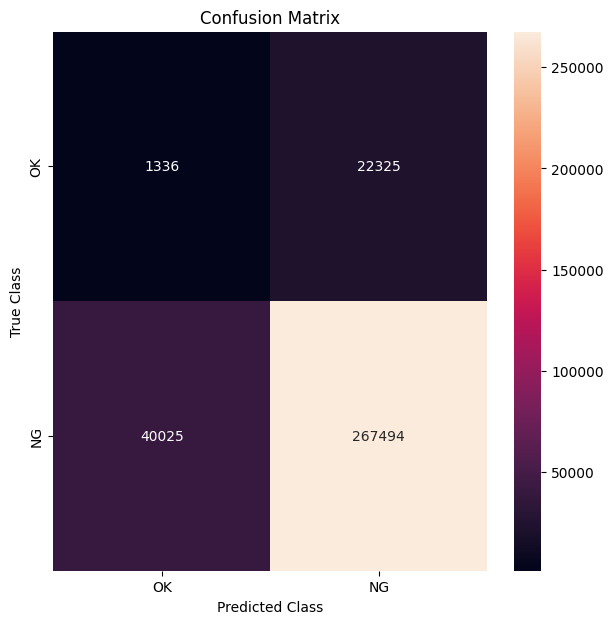

In [112]:
plt.figure(figsize=(7, 7))
sns.heatmap(classify, xticklabels=['OK', 'NG'], yticklabels=['OK', 'NG'], annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

In [114]:
p = precision_score(pred_df['TAG2'], pred_df['TAG'])
print("precision : %0.4f" %p)
r = recall_score(pred_df['TAG2'], pred_df['TAG'])
print("recall : %0.4f" %r)
f1 = f1_score(pred_df['TAG2'], pred_df['TAG'])
print("f1-score : %0.4f" %f1)
acc = accuracy_score(pred_df['TAG2'], pred_df['TAG'])
print("recall : %0.4f" %acc)

precision : 0.9230
recall : 0.8698
f1-score : 0.8956
recall : 0.8117


In [115]:
from sklearn.metrics import classification_report
print(classification_report(pred_df['TAG2'], pred_df['TAG']))

              precision    recall  f1-score   support

         0.0       0.03      0.06      0.04     23661
         1.0       0.92      0.87      0.90    307519

    accuracy                           0.81    331180
   macro avg       0.48      0.46      0.47    331180
weighted avg       0.86      0.81      0.83    331180



In [116]:
df_result = pred_df.copy()
df_result.rename(columns = {'TAG' : 'pred'}, inplace = True)

# SHAP

In [117]:
import shap
shap.initjs()

In [118]:
train_shap = pd.DataFrame(X_train_values,columns=feature_cols)
train_shap

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,Measurement_error,MW_Period_Second
0,0.345420,0.064552,0.927941,0.333333,0.0,0.253756
1,0.238550,0.043406,0.895588,0.333333,0.0,0.253756
2,0.297710,0.085698,0.894118,0.333333,0.0,0.253756
3,0.135496,0.117974,0.891176,0.333333,0.0,0.253756
4,0.935115,0.966055,0.888235,0.666667,0.0,0.253756
...,...,...,...,...,...,...
503995,0.877863,0.972732,0.214706,0.666667,0.0,0.787980
503996,0.139313,0.112410,0.213235,0.166667,0.0,0.787980
503997,0.362595,0.109627,0.210294,0.333333,0.0,0.787980
503998,0.311069,0.051753,0.207353,0.333333,0.0,0.787980


In [119]:
test_feature[:50].shape

(50, 20, 6)

In [161]:
e = shap.DeepExplainer(model, test_feature[:100])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [162]:
shap_values = e.shap_values(test_feature[:10])

In [181]:
shap.force_plot(e.expected_value, shap_values[0][0], test_feature[100],feature_names=feature_cols)

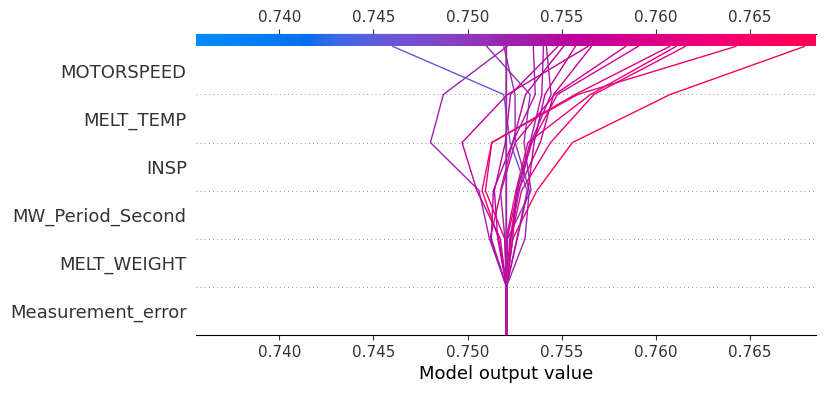

In [164]:
shap.decision_plot(e.expected_value[0], shap_values[0][0], 
                   features = test_feature[10], feature_names = feature_cols)

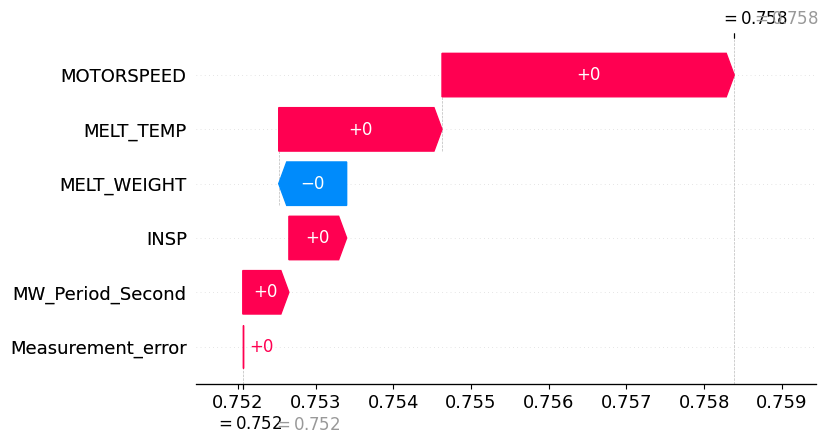

In [190]:
shap.plots._waterfall.waterfall_legacy(e.expected_value[0], 
                                       shap_values[0][0][1], feature_names = feature_cols)

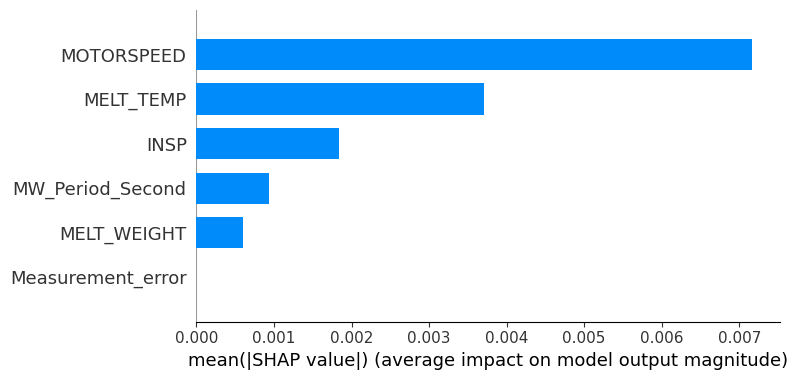

In [178]:
shap.summary_plot(shap_values[0][1], plot_type = 'bar', feature_names = feature_cols)

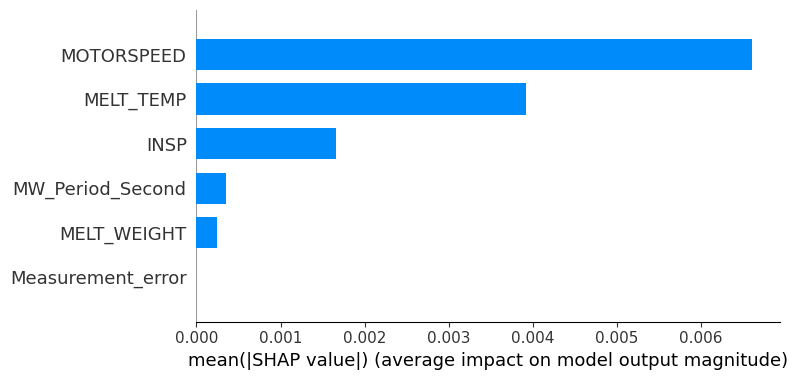

In [189]:
shap.summary_plot(shap_values[0][5], test_feature[10] ,plot_type="bar", 
                  class_names= ['OK','NG'], feature_names = feature_cols)